# 3MD3220: Reinforcement Learning - Individual Assignment

**Author:** Alexandre Boistard 
**Date:** March 2025

---

## Introduction

This notebook presents the implementation and comparison of two 
reinforcement learning agents— a Monte Carlo-based agent and a Sarsa 
agent—applied to the Text Flappy Bird (TFB) environment. 

In this notebook, two RL approaches are implemented:
1. A **Monte Carlo-based agent** that learns by averaging returns over 
complete episodes.
2. A **Sarsa agent** that utilizes eligibility traces to incrementally 
update its policy based on temporal-difference error.

The notebook is structured as follows:
- **Preliminaries:** Importing libraries, environment setup, and state 
discretization functions.
- **Agent Implementations:** Detailed code for both the Monte Carlo and 
Sarsa(λ) agents.
- **Training and Evaluation:** Training loops, performance tracking, and 
parameter sweeps.
- **Results and Analysis:** Visualization of rewards, state-value functions,
 and discussion of findings.

This structured approach allows us to compare the convergence properties, 
stability, and adaptability of both agents under different environmental 
configurations.

Environment configuration: {'height': 15, 'width': 20, 'pipe_gap': 4}
Random seeds set for reproducibility.


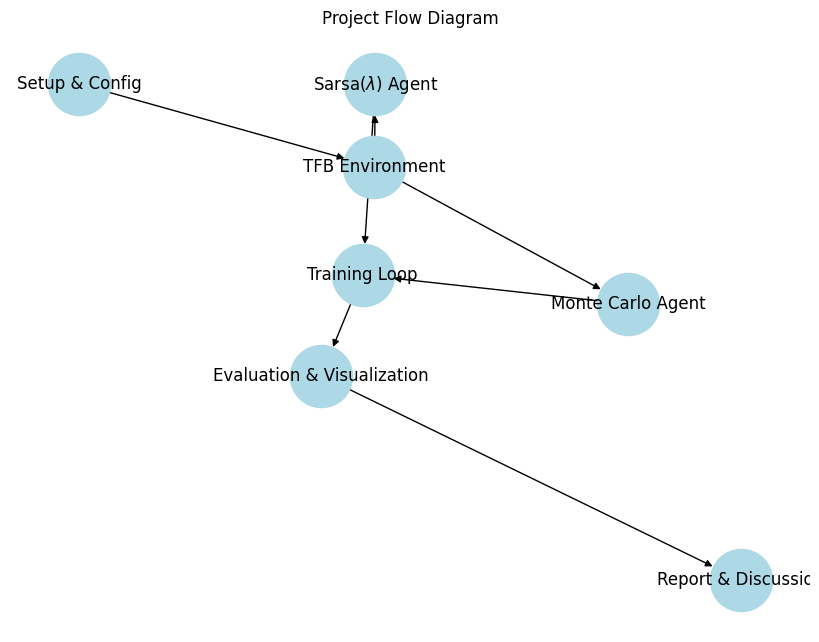

In [109]:
# Step 1.1: Environment and Reproducibility Setup
import numpy as np
import random
import matplotlib.pyplot as plt
import os, sys
import gymnasium as gym
import time
from collections import defaultdict
from tqdm import tqdm
from rl_glue import RLGlue

# Set environment parameters
env_config = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}

# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

print("Environment configuration:", env_config)
print("Random seeds set for reproducibility.")

# Step 1.2: Visual Project Flow Diagram
import networkx as nx

# Define the high-level components of the project
G = nx.DiGraph()
G.add_edges_from([
    ("Setup & Config", "TFB Environment"),
    ("TFB Environment", "Monte Carlo Agent"),
    ("TFB Environment", "Sarsa($\lambda$) Agent"),
    ("Monte Carlo Agent", "Training Loop"),
    ("Sarsa($\lambda$) Agent", "Training Loop"),
    ("Training Loop", "Evaluation & Visualization"),
    ("Evaluation & Visualization", "Report & Discussion")
])

pos = nx.spring_layout(G)
plt.figure(figsize=(8, 6))
nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=2000, arrows=True)
plt.title("Project Flow Diagram")
plt.show()


In [110]:
# Step 2: Initialize the TFB Environment
from gymnasium.envs.registration import register

register(
    id='TextFlappyBird-v0',
    entry_point='text_flappy_bird_gym.envs:TextFlappyBirdEnvSimple'
) ## can be deleted, forces the access to the environment if the environment 
# if necessary

env = gym.make('TextFlappyBird-v0', **env_config)
print("Environment initialized and rendered successfully.")

Environment initialized and rendered successfully.


In [111]:
## step 2.1: get some general observation on the env
# Print basic information about the environment.
print("Environment Observation Space:", env.observation_space)
print("Environment Action Space:", env.action_space)

# Reset the environment to get the initial state.
initial_state = env.reset()
print("\nInitial observation type:", type(initial_state))
print("Initial observation content:")

# If the observation is a dictionary, print its keys and the dictionary.
if isinstance(initial_state, dict):
    print("Observation keys:", list(initial_state.keys()))
    for key, value in initial_state.items():
        print(f"{key}: {value}")
# If it's a numpy array or another type, print directly.
else:
    print(initial_state)

Environment Observation Space: Tuple(Discrete(14), Discrete(22, start=-11))
Environment Action Space: Discrete(2)

Initial observation type: <class 'tuple'>
Initial observation content:
((13, 3), {'score': 0, 'player': [6, 7], 'distance': np.float64(13.341664064126334)})


In [153]:
obs = env.reset()
print(obs)
## we first play randomly
# iterate
while True:

    # Select next action
    action = env.action_space.sample()  # for an agent, action = agent.policy(observation)

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)
    print(reward, info)
    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS

    # If player is dead break
    if done:
        break

env.close()


((13, -3), {'score': 0, 'player': [6, 7], 'distance': np.float64(13.341664064126334)})
1 {'score': 0, 'player': [6, 6], 'distance': np.float64(12.649110640673518)}
Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[      @           | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=-4)
1 {'score': 0, 'player': [6, 5], 'distance': np.float64(12.083045973594572)}
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[      @          |  ]
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[      

In [318]:
class MonteCarloAgent:
    def __init__(self, env, alpha, gamma=1.0, eps_start=1.0, eps_decay=0.99999, eps_min=0.05, rand_gen=0):
        """
        Initializes the Monte Carlo agent.
        
        Parameters:
            env: The environment following the OpenAI Gym interface.
            alpha: Step-size parameter.
            gamma: Discount factor.
            eps_start: Initial epsilon value for the epsilon-greedy policy.
            eps_decay: Multiplicative factor for decreasing epsilon per episode.
            eps_min: Minimum epsilon value.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.nA = env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.rand_gen = np.random.default_rng(rand_gen)

    def get_probs(self, Q_s, epsilon):
        """ obtains the action probabilities corresponding to epsilon-greedy policy """
        policy_s = np.ones(self.nA) * epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] += 1 - epsilon 
        return policy_s

    def generate_episode_from_Q(self, epsilon,env=None):
        """ generates an episode from following the epsilon-greedy policy """
        if env==None:
            env = self.env
            
        episode = []
        state = env.reset()[0]
        while True:
            action = np.random.choice(np.arange(self.nA), 
            p=self.get_probs(self.Q[state], epsilon)) \
            if state in self.Q else env.action_space.sample()
            # take a step in the environement 
            next_state, reward, done, _, info = env.step(action) 
            episode.append((state, action, reward,info['score']))
            state = next_state
            if done:
                break
        return episode

    def update_Q(self, episode):
        """ updates the action-value function estimate using the most recent episode """
        states, actions, rewards, current_score = zip(*episode)
        # prepare for discounting
        discounts = np.array([self.gamma**i for i in range(len(rewards)+1)])
        for i, state in enumerate(states):
            old_Q = self.Q[state][actions[i]]
            self.Q[state][actions[i]] = old_Q + self.alpha * (np.dot(discounts[:len
        (rewards)-i], rewards[i:]) - old_Q)
        return self.Q


    def train(self, num_episodes, display=False):
        nA = self.nA
        self.Q = defaultdict(lambda: np.zeros(nA))
        epsilon = self.eps_start
        scores = []  
        for i_episode in range(1, num_episodes+1):
            if display and i_episode % 1000 == 0:
                print(f"\rEpisode {i_episode}/{num_episodes}.", end="")
                sys.stdout.flush()
            # Decay epsilon
            epsilon = max(epsilon * self.eps_decay, self.eps_min)
            # Generate an episode using the current Q
            episode = self.generate_episode_from_Q(epsilon)
            # Compute the score for this episode
            scores.append(max([score for _,_,_,score in episode])) 
            # Update Q based on the episode
            self.Q = self.update_Q(episode)
        # Build the final policy from the updated Q-table
        policy = {state: np.argmax(actions) for state, actions in self.Q.items()}
        return policy, self.Q, scores


In [302]:
class SARSALambdaAgent:
    def __init__(self, env, alpha, lambda_, gamma=1.0, eps_start=1.0, 
                 eps_decay=0.99999, eps_min=0.05, rand_gen=0):
        """
        Initializes the SARSA(lambda) agent.
        
        Parameters:
            env: The environment following the OpenAI Gym interface.
            alpha: Step-size parameter.
            gamma: Discount factor.
            eps_start: Initial epsilon for the epsilon-greedy policy.
            eps_decay: Multiplicative factor for decreasing epsilon per episode.
            eps_min: Minimum epsilon value.
            lambda_: Eligibility trace decay parameter.
            rand_gen: Random seed.
        """
        self.env = env
        self.alpha = alpha
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_decay = eps_decay
        self.eps_min = eps_min
        self.lambda_ = lambda_
        self.nA = env.action_space.n
        self.Q = defaultdict(lambda: np.zeros(self.nA))
        self.E = defaultdict(lambda: np.zeros(self.nA))
        self.rand_gen = np.random.default_rng(rand_gen)

    def get_probs(self, Q_s, epsilon):
        """Obtains the action probabilities corresponding to an epsilon-greedy policy."""
        policy_s = np.ones(self.nA) * epsilon / self.nA
        best_a = np.argmax(Q_s)
        policy_s[best_a] += 1 - epsilon 
        return policy_s

    def train(self, num_episodes, display=False):
        """
        Train the SARSA(lambda) agent over a number of episodes.
        
        Returns:
            policy: A dictionary mapping each state to its greedy action.
            Q: The final Q-table.
            scores: A list of episode returns.
        """
        epsilon = self.eps_start
        scores = []
        for i_episode in range(1, num_episodes+1):
            if display and i_episode % 1000 == 0:
                print(f"\rEpisode {i_episode}/{num_episodes}", end="")
            state = self.env.reset()[0]
            # Reset eligibility traces at the start of each episode.
            self.E = defaultdict(lambda: np.zeros(self.nA))
            # Choose action using epsilon-greedy policy.
            if state in self.Q:
                action = np.random.choice(np.arange(self.nA), p=self.get_probs(self.Q[state], epsilon))
            else:
                action = self.env.action_space.sample()
            episode_return = 0
            done = False
            while not done:
                next_state, reward, done, _, info = self.env.step(action)
                episode_return += reward
                # Choose next action if not terminal.
                if not done:
                    if next_state in self.Q:
                        next_action = np.random.choice(np.arange(self.nA), p=self.get_probs(self.Q[next_state], epsilon))
                    else:
                        next_action = self.env.action_space.sample()
                    Q_next = self.Q[next_state][next_action]
                else:
                    next_action = None
                    Q_next = 0

                Q_current = self.Q[state][action]
                # TD error: δ = r + γ Q(s', a') - Q(s,a)
                delta = reward + self.gamma * Q_next - Q_current
                
                # Update eligibility trace for current state-action (using replacing traces)
                self.E[state][action] = 1
                
                # Update Q-values for all state-action pairs using eligibility traces.
                for s in self.E:
                    self.Q[s] += self.alpha * delta * self.E[s]
                    self.E[s] *= self.gamma * self.lambda_
                
                state = next_state
                action = next_action
            scores.append(episode_return)
            epsilon = max(epsilon * self.eps_decay, self.eps_min)
        
        # Build the final greedy policy.
        policy = {s: np.argmax(actions) for s, actions in self.Q.items()}
        return policy, self.Q, scores

    def generate_episode(self, epsilon, env=None):
        """
        Generates an episode using the current Q-table and an epsilon-greedy policy.
        
        Returns:
            episode: A list of (state, action, reward, info['score']) tuples.
        """
        if env==None:
            env = self.env
            
        episode = []
        state = env.reset()[0]
        while True:
            action = np.random.choice(np.arange(self.nA), 
                                      p=self.get_probs(self.Q[state], epsilon)) \
                     if state in self.Q else env.action_space.sample()
            next_state, reward, done, _, info = env.step(action)
            episode.append((state, action, reward, info['score']))
            state = next_state
            if done:
                break
        return episode


In [255]:
# obtain the estimated optimal policy and action-value function
alpha = 0.02
num_ep = 5000
sarsa_param_lambda = 0.5
mc_agent = MonteCarloAgent(env,alpha)
sarsa_agent = SARSALambdaAgent(env,alpha,sarsa_param_lambda)
mc_policy, mc_Q, _ = mc_agent.train(num_ep,display=True)
sarsa_policy, sarsa_Q, _ = sarsa_agent.train(num_ep,display=True)

Episode 5000/5000.

In [256]:
# obtain the corresponding state-value function and plot
mc_V = dict((k,np.max(v)) for k, v in mc_Q.items())
sarsa_V = dict((k,np.max(v)) for k, v in sarsa_Q.items())

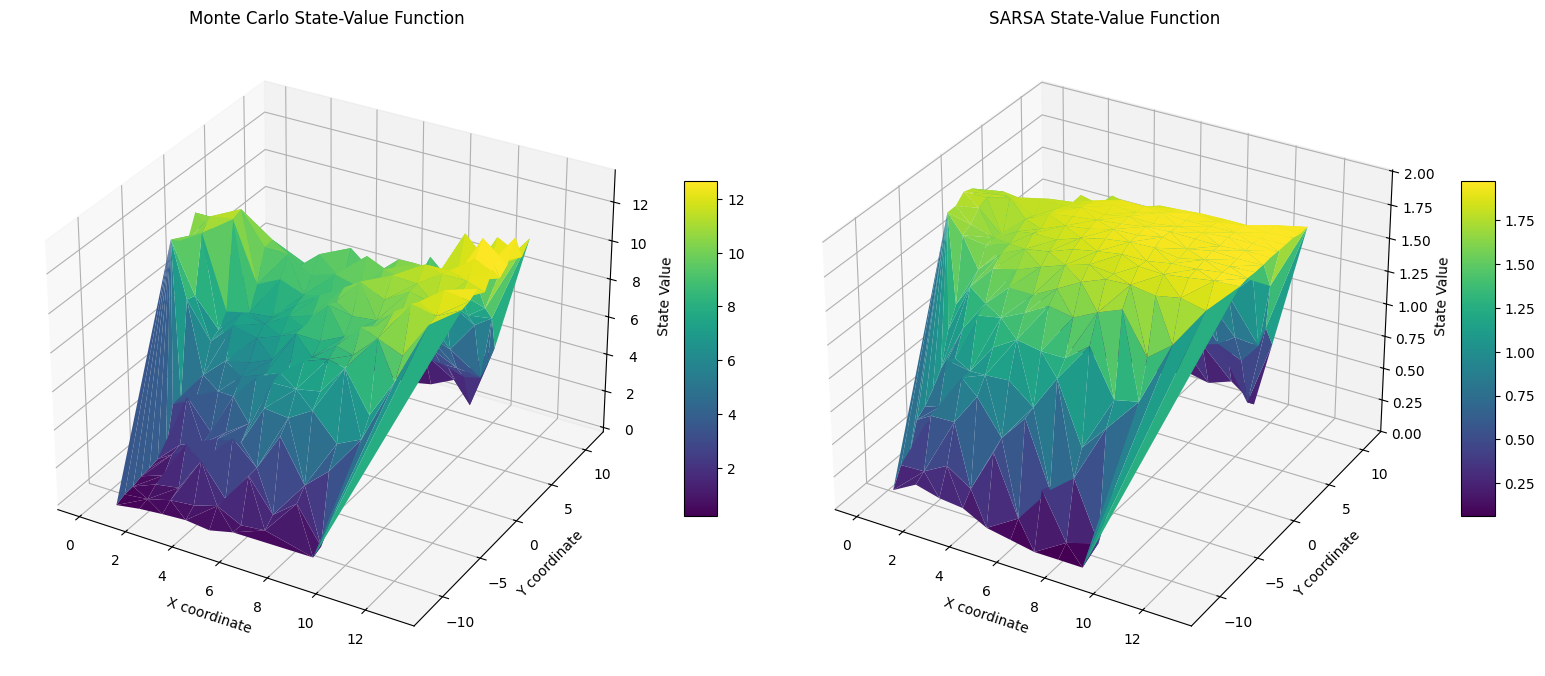

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # This import registers the 3D projection


# Convert dictionary keys and values into arrays
mc_keys = np.array(list(mc_V.keys()))
sarsa_keys = np.array(list(sarsa_V.keys()))

sarsa_values = np.array(list(sarsa_V.values()))
mc_values = np.array(list(mc_V.values()))

# Extract coordinates for Monte Carlo agent
mc_X = mc_keys[:, 0]
mc_Y = mc_keys[:, 1]
mc_Z = mc_values

# Extract coordinates for SARSA agent
sarsa_X = sarsa_keys[:, 0]
sarsa_Y = sarsa_keys[:, 1]
sarsa_Z = sarsa_values

# Create a figure with two side-by-side subplots
fig = plt.figure(figsize=(16, 7))

# Monte Carlo 3D plot
ax1 = fig.add_subplot(121, projection='3d')
surf1 = ax1.plot_trisurf(mc_X, mc_Y, mc_Z, cmap='viridis', edgecolor='none')
ax1.set_xlabel('X coordinate')
ax1.set_ylabel('Y coordinate')
ax1.set_zlabel('State Value')
ax1.set_title('Monte Carlo State-Value Function')
fig.colorbar(surf1, ax=ax1, shrink=0.5, aspect=10)

# SARSA 3D plot
ax2 = fig.add_subplot(122, projection='3d')
surf2 = ax2.plot_trisurf(sarsa_X, sarsa_Y, sarsa_Z, cmap='viridis', edgecolor='none')
ax2.set_xlabel('X coordinate')
ax2.set_ylabel('Y coordinate')
ax2.set_zlabel('State Value')
ax2.set_title('SARSA State-Value Function')
fig.colorbar(surf2, ax=ax2, shrink=0.5, aspect=10)

plt.tight_layout()
plt.show()

In [200]:
## we make our agent play !!! 
obs = env.reset()[0]
# iterate
i=0
while True:

    # Select next action
    action = mc_policy[obs] # choose either mc or sarsa

    # Appy action and return new observation of the environment
    obs, reward, done, _, info = env.step(action)

    # Render the game
    os.system("clear")
    sys.stdout.write(env.render())
    time.sleep(0.2) # FPS
    i+=1
    # If player is dead break
    if done or i==100:
        break

env.close()

Text Flappy Bird!
Score: 0
----------------------
[                  | ]
[                  | ]
[                    ]
[                    ]
[                    ]
[                    ]
[      @           | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
[                  | ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=12,dy=2)
Text Flappy Bird!
Score: 0
----------------------
[                 |  ]
[                 |  ]
[                    ]
[                    ]
[                    ]
[      @             ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
[                 |  ]
^^^^^^^^^^^^^^^^^^^^^^
Player Action (Flap)
Distance From Pipe (dx=11,dy=1)
Text Flappy Bird!
Score: 0
----------------------
[       

In [276]:
from tqdm import trange
# ---------- Monte Carlo Experiment Function ----------

def run_monte_carlo_experiment(env, agent_class, alpha=0.1, gamma=1.0,
                               eps_start=1.0, eps_decay=0.99999, eps_min=0.05,
                               num_runs=10, num_episodes=500, seed_offset=0):
    all_rewards = np.zeros((num_runs, num_episodes))
    all_scores = np.zeros((num_runs, num_episodes))
    for run in range(num_runs):
        agent = agent_class(env, alpha=alpha, gamma=gamma,
                            eps_start=eps_start, eps_decay=eps_decay,
                            eps_min=eps_min, rand_gen=seed_offset + run)
        epsilon = eps_start
        for ep in trange(num_episodes, desc=f"MC: α={alpha}, Run: {run+1}/{num_runs}", leave=False):
            episode = agent.generate_episode_from_Q(epsilon)
            ep_return = sum(step[2] for step in episode)
            final_score = max(step[3] for step in episode)
            all_rewards[run, ep] = ep_return
            all_scores[run, ep] = final_score
            agent.update_Q(episode)
            epsilon = max(epsilon * eps_decay, eps_min)
    return all_rewards, all_scores

# ---------- SARSA(lambda) Experiment Function ----------

def run_sarsa_experiment(env, agent_class, alpha=0.1, lambda_=0.9, gamma=1.0,
                         eps_start=1.0, eps_decay=0.99999, eps_min=0.05,
                         num_runs=10, num_episodes=500, seed_offset=0):

    all_rewards = np.zeros((num_runs, num_episodes))
    all_scores  = np.zeros((num_runs, num_episodes))    
    for run in range(num_runs):
        agent = agent_class(env, alpha=alpha, lambda_=lambda_, gamma=gamma,
                            eps_start=eps_start, eps_decay=eps_decay,
                            eps_min=eps_min, rand_gen=seed_offset + run)
        epsilon = eps_start
        
        for ep in trange(num_episodes, desc=f"SARSA: α={alpha}, λ={lambda_}, Run: {run+1}/{num_runs}", leave=False):
            state = env.reset()[0]
            agent.E = defaultdict(lambda: np.zeros(agent.nA))
            
            if state in agent.Q:
                action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[state], epsilon))
            else:
                action = env.action_space.sample()
            
            episode_return = 0
            done = False
            
            while not done:
                next_state, reward, done, _, info = env.step(action)
                episode_return += reward
                episode_score = info['score']                
                if not done:
                    if next_state in agent.Q:
                        next_action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[next_state], epsilon))
                    else:
                        next_action = env.action_space.sample()
                    Q_next = agent.Q[next_state][next_action]
                else:
                    next_action = None
                    Q_next = 0

                Q_current = agent.Q[state][action]
                delta = reward + gamma * Q_next - Q_current
                agent.E[state][action] = 1

                for s in agent.E:
                    agent.Q[s] += alpha * delta * agent.E[s]
                    agent.E[s] *= gamma * lambda_
                
                state = next_state
                action = next_action
            
            # For this experiment, we use episode_return as both total reward and final score.
            all_rewards[run, ep] = episode_return
            all_scores[run, ep]  = episode_score

            epsilon = max(epsilon * eps_decay, eps_min)
    
    return all_rewards, all_scores

def bin_and_plot_data(all_data, bin_size=100, confidence=0.95):
    """
    Bins the data into windows of 'bin_size' episodes, and computes the mean and 95% confidence interval.
    """
    num_runs, num_episodes = all_data.shape
    num_bins = num_episodes // bin_size
    binned_x, binned_means, binned_errors = [], [], []
    for i in range(num_bins):
        start = i * bin_size
        end = start + bin_size
        run_bin_means = np.mean(all_data[:, start:end], axis=1)
        mean_bin = np.mean(run_bin_means)
        std_bin = np.std(run_bin_means)
        se = std_bin / np.sqrt(num_runs)
        t_value = 1.96  # approximate value for 95% confidence
        error = t_value * se
        binned_x.append(start + bin_size / 2)
        binned_means.append(mean_bin)
        binned_errors.append(error)
    return np.array(binned_x), np.array(binned_means), np.array(binned_errors)


In [279]:
# ---------- Main Experiment Loop ----------
env_config = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}
env = gym.make('TextFlappyBird-v0', **env_config)

# For Monte Carlo experiments: vary only alpha.
alpha_values = [0.01, 0.1, 0.5]
num_runs = 1          # (Increase for robust averages; here one run is used for speed)
num_episodes = 50000  # (Change as needed)

all_rewards_mc = {}
all_scores_mc = {}

for alpha in alpha_values:
    rewards, scores = run_monte_carlo_experiment(
        env=env,
        agent_class=MonteCarloAgent,   # your Monte Carlo agent class
        alpha=alpha,
        gamma=1.0,
        eps_start=1.0,
        eps_decay=0.9999,
        eps_min=0.05,
        num_runs=num_runs,
        num_episodes=num_episodes,
        seed_offset=42
    )
    all_rewards_mc[alpha] = rewards
    all_scores_mc[alpha] = scores

In [296]:
# For SARSA experiments: vary both alpha and lambda.
alpha_values = [0.1]
num_runs = 1          # (Increase for robust averages; here one run is used for speed)
num_episodes = 50000  # (Change as needed)
sarsa_lambda_values = [0.5]  # (e.g., λ=0 corresponds to one-step SARSA)
all_rewards_sarsa = {}
all_scores_sarsa = {}

for alpha in alpha_values:
    for lambda_ in sarsa_lambda_values:
        key = (alpha, lambda_)
        rewards, scores = run_sarsa_experiment(
            env=env,
            agent_class=SARSALambdaAgent,  # your SARSA agent class that accepts lambda_
            alpha=alpha,
            lambda_=lambda_,
            gamma=1.0,
            eps_start=1.0,
            eps_decay=0.9999,
            eps_min=0.05,
            num_runs=num_runs,
            num_episodes=num_episodes,
            seed_offset=42
        )
        all_rewards_sarsa[key] = rewards
        all_scores_sarsa[key] = scores

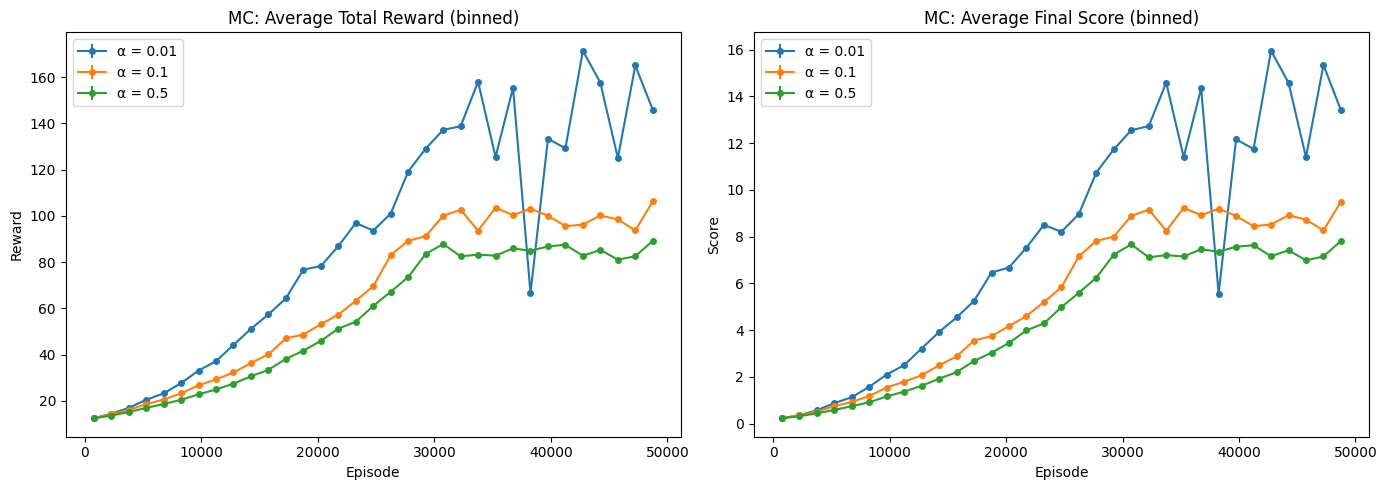

In [294]:
import matplotlib.pyplot as plt

# ----- Monte Carlo Plots -----
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

### PARAMETERS ####
bin_size = 1500
##################

for alpha in alpha_values:
    x_r, mean_r, err_r = bin_and_plot_data(all_rewards_mc[alpha], 
                                           bin_size=bin_size)
    x_s, mean_s, err_s = bin_and_plot_data(all_scores_mc[alpha], 
                                           bin_size=bin_size)

    axes[0].errorbar(x_r, mean_r, yerr=err_r, fmt='o-', label=f"α = {alpha}",
                     markersize=4)
    axes[1].errorbar(x_s, mean_s, yerr=err_s, fmt='o-', label=f"α = {alpha}",
                     markersize=4)

axes[0].set_title("MC: Average Total Reward (binned)")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].legend()

axes[1].set_title("MC: Average Final Score (binned)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Score")
axes[1].legend()

plt.tight_layout()
plt.show()

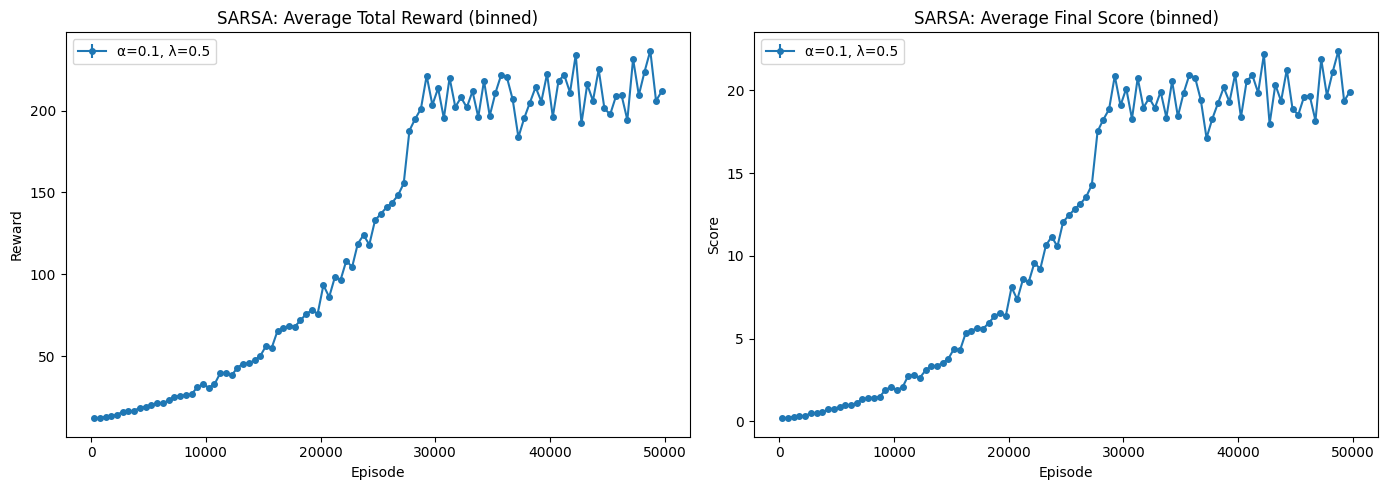

In [297]:
from itertools import product

# ----- SARSA Plots -----
####### PARAMETERS #########
#sarsa_params = [(0.01, 0.9),(0.1, 0.5),(0.5, 0.9)]
sarsa_params = list(product(alpha_values, sarsa_lambda_values))
bin_size = 500
###########################################


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for (alpha, lambda_) in sarsa_params:
    # Check that the keys exist in your results dictionaries.
    if (alpha, lambda_) not in all_rewards_sarsa or (alpha, lambda_) not in all_scores_sarsa:
        print(f"Data for (α={alpha}, λ={lambda_}) not found.")
        continue

    # Compute binned data for rewards and scores.
    x_r, mean_r, err_r = bin_and_plot_data(all_rewards_sarsa[(alpha, lambda_)], bin_size=bin_size)
    x_s, mean_s, err_s = bin_and_plot_data(all_scores_sarsa[(alpha, lambda_)], bin_size=bin_size)

    # Plot on the same axes.
    axes[0].errorbar(x_r, mean_r, yerr=err_r, fmt='o-', label=f"α={alpha}, "
                                                              f"λ={lambda_}",
                     markersize=4)
    axes[1].errorbar(x_s, mean_s, yerr=err_s, fmt='o-', label=f"α={alpha}, "
                                                              f"λ={lambda_}",
                     markersize=4)

axes[0].set_title("SARSA: Average Total Reward (binned)")
axes[0].set_xlabel("Episode")
axes[0].set_ylabel("Reward")
axes[0].legend()

axes[1].set_title("SARSA: Average Final Score (binned)")
axes[1].set_xlabel("Episode")
axes[1].set_ylabel("Score")
axes[1].legend()

plt.tight_layout()
plt.show()

In [315]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def train_and_evaluate(agent_class, train_env, test_env, 
                       num_train_episodes=1000, num_test_episodes=100, 
                       epsilon_train=1.0, epsilon_test=0.0, **agent_params):

    # Create an agent instance with the training environment.
    agent = agent_class(train_env, **agent_params)
    
    # Train the agent and collect training scores.
    train_scores = []
    epsilon = epsilon_train
    for i_episode in trange(num_train_episodes, desc="Training"):
        state = train_env.reset()[0]
        # Reset eligibility traces at the start of each episode.
        agent.E = agent.__class__.E = {}  # Alternatively: agent.E = defaultdict(lambda: np.zeros(agent.nA))
        # Ensure eligibility traces are reinitialized (here we reinitialize via new defaultdict)
        from collections import defaultdict
        agent.E = defaultdict(lambda: np.zeros(agent.nA))
        
        # Choose initial action.
        if state in agent.Q:
            action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[state], epsilon))
        else:
            action = train_env.action_space.sample()
        
        episode_return = 0
        done = False
        while not done:
            next_state, reward, done, _, info = train_env.step(action)
            episode_return += reward
            # Choose next action (if not terminal).
            if not done:
                if next_state in agent.Q:
                    next_action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[next_state], epsilon))
                else:
                    next_action = train_env.action_space.sample()
                Q_next = agent.Q[next_state][next_action]
            else:
                next_action = None
                Q_next = 0
                
            Q_current = agent.Q[state][action]
            # TD error: δ = r + γ Q(s', a') - Q(s, a)
            delta = reward + agent.gamma * Q_next - Q_current
            
            # Update eligibility trace (replacing traces)
            agent.E[state][action] = 1
            
            # Update Q-values for all state-action pairs using eligibility traces.
            for s in agent.E:
                agent.Q[s] += agent.alpha * delta * agent.E[s]
                agent.E[s] *= agent.gamma * agent.lambda_
            
            state = next_state
            action = next_action
        
        train_scores.append(episode_return)
        epsilon = max(epsilon * agent.eps_decay, agent.eps_min)
    
    # Define a helper function to evaluate the agent (without updating Q).
    def evaluate_agent(env, n_episodes, epsilon_eval):
        returns = []
        for _ in trange(n_episodes, desc="Evaluating", leave=False):
            state = env.reset()[0]
            episode_return = 0
            done = False
            while not done:
                if state in agent.Q:
                    action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[state], epsilon_eval))
                else:
                    action = env.action_space.sample()
                next_state, reward, done, _, info = env.step(action)
                episode_return += reward
                state = next_state
            returns.append(episode_return)
        return returns
    
    # Evaluate on the training environment.
    eval_train_returns = evaluate_agent(train_env, num_test_episodes, epsilon_test)
    # Evaluate on the test environment.
    eval_test_returns  = evaluate_agent(test_env, num_test_episodes, epsilon_test)
    
    return train_scores, eval_train_returns, eval_test_returns


# ================================
# Example Usage:
# ================================

env_config = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}
env_config_test = {
    'height': 20,
    'width': 25,
    'pipe_gap': 6
}

train_env = gym.make('TextFlappyBird-v0', **env_config)

def evaluate_agent(agent, env, n_simulations=50, epsilon=0.05):
    returns = [] ; scores= []
    for _ in range(n_simulations):
        episode = agent.generate_episode(epsilon, env)
        ep_return = sum(step[2] for step in episode)
        ep_score = max(step[3] for step in episode)
        returns.append(ep_return)
        scores.append(ep_score)
    return [np.mean(returns), np.mean(scores)]

n_simul = 100
agent = SARSALambdaAgent(env,alpha=0.1,lambda_=0.5)
# Train the agent on the training environment using its built-in train method.
policy, Q, train_scores = agent.train(num_episodes=5000, display=True)


test_env  = gym.make('TextFlappyBird-v0', **env_config_test)  # Modify as needed
# Evaluate the trained agent on the training environment.
eval_train_returns = evaluate_agent(agent, train_env, n_simulations=n_simul)

# Evaluate the trained agent on a different (test) environment.
eval_test_returns = evaluate_agent(agent, test_env, n_simulations=n_simul)
print('\n')
print(f'Total return on the same kind of env: avg total '
      f'return is {eval_train_returns[0]} and avg score: '
      f'{eval_train_returns[1]}\n')
print(f'Total return on new env: avg total '
      f'return is {eval_test_returns[0]} and avg score: '
      f'{eval_test_returns[1]}\n')
print(f'mean performed on {n_simul} games generated by the trained model')

Episode 5000/5000

Total return on the same kind of env: avg total return is 231.45 and avg score: 21.9

Total return on new env: avg total return is 216.1 and avg score: 15.57

mean performed on 100 games generated by the trained model


In [319]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import trange

def train_and_evaluate(agent_class, train_env, test_env, 
                       num_train_episodes=1000, num_test_episodes=100, 
                       epsilon_train=1.0, epsilon_test=0.0, **agent_params):

    # Create an agent instance with the training environment.
    agent = agent_class(train_env, **agent_params)
    
    # Train the agent and collect training scores.
    train_scores = []
    epsilon = epsilon_train
    for i_episode in trange(num_train_episodes, desc="Training"):
        state = train_env.reset()[0]
        # Reset eligibility traces at the start of each episode.
        agent.E = agent.__class__.E = {}  # Alternatively: agent.E = defaultdict(lambda: np.zeros(agent.nA))
        # Ensure eligibility traces are reinitialized (here we reinitialize via new defaultdict)
        from collections import defaultdict
        agent.E = defaultdict(lambda: np.zeros(agent.nA))
        
        # Choose initial action.
        if state in agent.Q:
            action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[state], epsilon))
        else:
            action = train_env.action_space.sample()
        
        episode_return = 0
        done = False
        while not done:
            next_state, reward, done, _, info = train_env.step(action)
            episode_return += reward
            # Choose next action (if not terminal).
            if not done:
                if next_state in agent.Q:
                    next_action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[next_state], epsilon))
                else:
                    next_action = train_env.action_space.sample()
                Q_next = agent.Q[next_state][next_action]
            else:
                next_action = None
                Q_next = 0
                
            Q_current = agent.Q[state][action]
            # TD error: δ = r + γ Q(s', a') - Q(s, a)
            delta = reward + agent.gamma * Q_next - Q_current
            
            # Update eligibility trace (replacing traces)
            agent.E[state][action] = 1
            
            # Update Q-values for all state-action pairs using eligibility traces.
            for s in agent.E:
                agent.Q[s] += agent.alpha * delta * agent.E[s]
                agent.E[s] *= agent.gamma * agent.lambda_
            
            state = next_state
            action = next_action
        
        train_scores.append(episode_return)
        epsilon = max(epsilon * agent.eps_decay, agent.eps_min)
    
    # Define a helper function to evaluate the agent (without updating Q).
    def evaluate_agent(env, n_episodes, epsilon_eval):
        returns = []
        for _ in trange(n_episodes, desc="Evaluating", leave=False):
            state = env.reset()[0]
            episode_return = 0
            done = False
            while not done:
                if state in agent.Q:
                    action = np.random.choice(np.arange(agent.nA), p=agent.get_probs(agent.Q[state], epsilon_eval))
                else:
                    action = env.action_space.sample()
                next_state, reward, done, _, info = env.step(action)
                episode_return += reward
                state = next_state
            returns.append(episode_return)
        return returns
    
    # Evaluate on the training environment.
    eval_train_returns = evaluate_agent(train_env, num_test_episodes, epsilon_test)
    # Evaluate on the test environment.
    eval_test_returns  = evaluate_agent(test_env, num_test_episodes, epsilon_test)
    
    return train_scores, eval_train_returns, eval_test_returns


# ================================
# Example Usage:
# ================================

env_config = {
    'height': 15,
    'width': 20,
    'pipe_gap': 4
}
env_config_test = {
    'height': 20,
    'width': 25,
    'pipe_gap': 6
}

train_env = gym.make('TextFlappyBird-v0', **env_config)

def evaluate_agent(agent, env, n_simulations=50, epsilon=0.05):
    returns = [] ; scores= []
    for _ in range(n_simulations):
        episode = agent.generate_episode_from_Q(epsilon, env)
        ep_return = sum(step[2] for step in episode)
        ep_score = max(step[3] for step in episode)
        returns.append(ep_return)
        scores.append(ep_score)
    return [np.mean(returns), np.mean(scores)]

n_simul = 100
agent = MonteCarloAgent(env,alpha=0.1)
# Train the agent on the training environment using its built-in train method.
policy, Q, train_scores = agent.train(num_episodes=5000, display=True)


test_env  = gym.make('TextFlappyBird-v0', **env_config_test)  # Modify as needed
# Evaluate the trained agent on the training environment.
eval_train_returns = evaluate_agent(agent, train_env, n_simulations=n_simul)

# Evaluate the trained agent on a different (test) environment.
eval_test_returns = evaluate_agent(agent, test_env, n_simulations=n_simul)
print('\n')
print(f'Total return on the same kind of env: avg total '
      f'return is {eval_train_returns[0]} and avg score: '
      f'{eval_train_returns[1]}\n')
print(f'Total return on new env: avg total '
      f'return is {eval_test_returns[0]} and avg score: '
      f'{eval_test_returns[1]}\n')
print(f'mean performed on {n_simul} games generated by the trained model')

Episode 5000/5000.

Total return on the same kind of env: avg total return is 173.31 and avg score: 16.07

Total return on new env: avg total return is 170.16 and avg score: 12.07

mean performed on 100 games generated by the trained model


The results indicate that while the agent performs robustly in its training 
environment, it experiences a moderate performance drop in a novel environment. 
This suggests that although the agent generalizes reasonably well, some 
aspects of its learned behavior are tuned specifically to the training 
conditions, leading to reduced effectiveness when those conditions change.